==============================================================================================
# Practicum 5 - Part 1

==============================================================================================

## Delivery

Up to **1 point out of 10** will be penalized if the following requirements are not fulfilled:

- The questions introduced in the exercises must be answered.

- Implemented code should be commented.

- Add title to the figures to explain what is displayed.

- Comments need to be in **english**.

- The deliverable must be a file named **P5_Student1_Student2.zip** that includes:
    - The notebook P5_Student1_Student2.ipynb completed with the solutions to the exercises and their corresponding comments.

**Deadline: December 6th, 23:00 h**


==============================================================================================
##  Image search using textures
==============================================================================================

#### Problem we want to solve
- Given a query image **$x$** and a set of images **$X$** we would like to retreive the most similar to **$x$** images from  **$X$**.

The exercises of this notebook will show how we can perform image similarity search using:

- Gaussian filters
- Descriptors based on texture 
- Distance between images and similarity search


### Imports

In [148]:
%matplotlib inline

import time
import scipy
import numpy as np
import skimage
from skimage import filters
from skimage.io import imread
from skimage.color import rgb2gray, rgba2rgb
from skimage.transform import resize

import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [149]:
def show_img(image,titol):
    """
    auxiliar function that plot an image with the corresponding title
    """
    plt.imshow(image, cmap='gray')
    plt.title(titol)
    plt.axis('off')
    plt.show()

In [150]:
def plot_images_line(images, titles, size = (20,12)):
    """
    function that shows the images on the same canvas with their corresponding titles
        images: list of images we want to plot together
        titles: list of corresponding titles of the images
    """
    canvas, axs = plt.subplots(nrows=1, ncols=len(images), figsize= size)
    
    for index,image in enumerate(images):
        ax = axs[index]
        ax.imshow(image, cmap='gray')
        ax.axis('off')
        ax.set_title(titles[index])

In [151]:
def show_details(image):
    """
    auxiliar function that shows us the details of the image
        image: the image we want to see its details
    """
    print('Shape:',image.shape)
    print('Data type:',image.dtype)
    print('Max:',image.max())
    print('Min:', image.min())
    print('Size:',image.size)

In [152]:
def plot_images(images,titles,ncols,figsize = (20,15)):
    """
    function that displays a set of images
        images: list of images
        titles: list of image titles
        ncols: number of columns
    """
    nrows = len(images)//ncols
    
    if nrows == 1:
        plot_images_line(images,titles)
    
    elif ncols == 1:
        for i in range(len(images)):
            show_img(images[i],titles[i])
    else:
        fig, axs = plt.subplots(nrows=nrows, ncols=ncols,figsize=figsize)

        index = 0
        for i in range(nrows):
            for j in range(ncols):
                ax = axs[i,j]
                ax.imshow(images[index],cmap='gray')
                ax.set_title(titles[index])
                ax.axis('off')
                index += 1

        plt.show()

In [153]:
def plot_detail(image):
    """
    auxiliar function that shows us the details of the image
        image: the image we want to see its details
    """
    print('Shape:',image.shape)
    print('Data type:',image.dtype)
    print('Max:',image.max())
    print('Min:', image.min())
    print('Size:',image.size)

In [154]:
def plot_details(images,titles):
    """
    show the details of a set of image 
    """
    for index,image in enumerate(images):
        print('\nDetails of ',titles[index])
        plot_detail(image)

# 1 Derivative of Gaussians aka Leung-Malik (LM) Filter Bank
We can apply a collection of multiple filters that we call a filter bank. Note that if we apply $D$ filters our feature vectors will be $D$ dimensional.

The following image shows a filter bank. In the filter bank we typically want filters to capture a combination of scales, orientations of different types of patterns. This particular filter bank is The Derivative-of-Gaussians or as known as Leung-Malik (LM) Filter Bank.

<img src="./images_notebook/filter_bank.png">


We import Leung-Malik filters as follows:

In [155]:
import LM_filters
filter_bank = LM_filters.makeLMfilters()
print("The shape of the filter_bank is", filter_bank.shape)
print("The shape of one filter is", filter_bank[:,:,2].shape)

The shape of the filter_bank is (49, 49, 48)
The shape of one filter is (49, 49)


### Plotting all filters

Plot the created filters as images similar to the figure above.

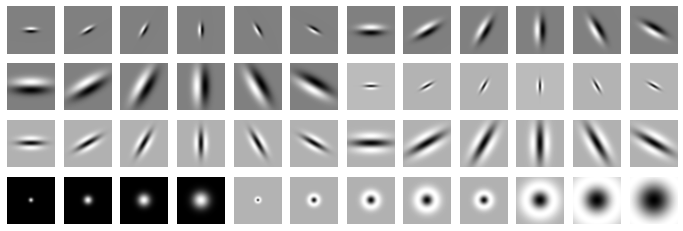

In [156]:
# Make plots appear and store within the notebook
%matplotlib inline
# Having all the filters we plot them all
fig, axs = plt.subplots(nrows=4, ncols=12,figsize=(12,4))
# First order derivative Gaussian Filter -> 18 filters
# Second order derivative Gaussian Filter -> 18 filters
# Gaussian and Laplacian Filter -> 12 filters
index = 0
for i in range(4):
    for j in range(12):
        ax = axs[i,j]
        ax.imshow(filter_bank[:,:,index], cmap='gray')
        ax.axis('off')
        index += 1
plt.show()

What are the different filters? Which is the size of the filters? How many filters there are?

In [157]:
def first_order_derivative_Gaussian():
    print('First_order_derivative_Gaussian Filter')
    for i in range(0,18):
        plt.subplot(3,6,i+1)
        plt.axis('off')
        plt.imshow(filter_bank[:,:,i], cmap = 'gray')

def second_order_derivative_Gaussian():
    print('Second_order_derivative_Gaussian Filter')
    for i in range(0,18):
        plt.subplot(3,6,i+1)
        plt.axis('off')
        plt.imshow(filter_bank[:,:,i+18], cmap = 'gray')


def gaussian_and_laplacian():
    print('Gaussian_and_Laplacian Filter')
    for i in range(0,12):
        plt.subplot(4,4,i+1)
        plt.axis('off')
        plt.imshow(filter_bank[:,:,i+36], cmap = 'gray')

First_order_derivative_Gaussian Filter


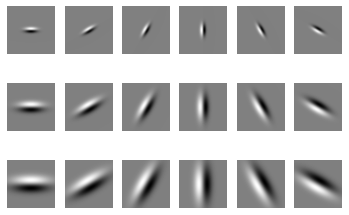

In [158]:
first_order_derivative_Gaussian()

Second_order_derivative_Gaussian Filter


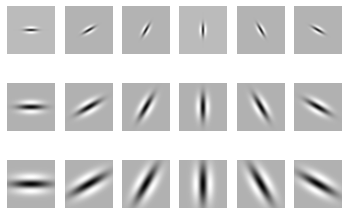

In [159]:
second_order_derivative_Gaussian()

Gaussian_and_Laplacian Filter


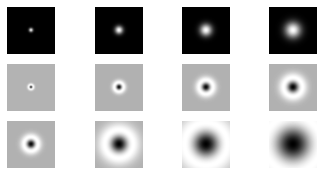

In [160]:
gaussian_and_laplacian()

> The edges corresponds to the first order derivates of Gaussian with the differents scales and orientations (18). The same with the bars, which are the second derivates (18) and the spots for the gaussian and laplacian (12).

> The size of each one is 49x49.

> And as we can see there are totally 48 different filters.

## 1. Extracting a feature vector for an image

**1.1** Read the image ``/images/pizza.jpg``, and resize it to 240𝑥240 pixels. Then, convert the image to grayscale and visualize both, the RGB and the grayscale images.

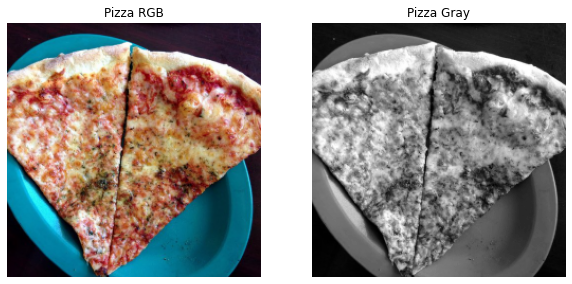

In [161]:
# We take the query image
pizza = imread('images/pizza.jpg')
# Resize to 240x240
pizza = resize(pizza,(240,240))
# Convert to grayscale
pizza_gray = rgb2gray(pizza)

# Visualise them
plot_images_line([pizza, pizza_gray], ["Pizza RGB", "Pizza Gray"], (10,5))

**1.2** Given $D=n\_{filters}$ filters from the filter bank and a single image `image`, make a function `get_image_features(image, filter_bank, n_filters)` that returns a feature vector of shape `n_filters`. The returned vector must contain at position $k$ the mean of the absolute value of the convolved image by filter $k$.

$$
\text{feat}(x) = \left( \text{mean}( |r_1|), \dots,\text{mean}(|r_D|) \right)
$$

Try the function with the previous image and print the feature vector.

**Hint**: The function should return a feature vector obtained by averaging each filter response on the image. Use a small number of filters to try your functions

In [162]:
from scipy.ndimage import convolve
def get_image_features(image, filter_bank, n_filters):
    """
    function that returns a feature vector of shape n_filters
        image: anyone else image
        filter_bank: all the filter we have
        n_filters: number of filter we use and the lenght of the feature vector requiered
    returns:
        feacture_vector[n_filters] where each element of the vector will be the mean of the absolute value of the convolved image by filter  𝑘
    """
    feature_vector = np.zeros(n_filters)
    
    for k in range(n_filters):
        # convolved image
        convolved = scipy.ndimage.convolve(image,filter_bank[:,:,k],mode = 'reflect')
        # mean of abs(convolved)
        feature_vector[k] = np.mean(abs(convolved))
    
    return feature_vector

In [163]:
## Try the function for pizza image
n_filters = 6
im_features = get_image_features(pizza_gray, filter_bank, n_filters)
assert len(im_features) == 6, "im_features must have len of 6"

In [164]:
print(im_features)

[0.01601324 0.01450963 0.01425697 0.01591414 0.01726521 0.01750963]


In [165]:
## Try the function for pizza image
n_filters = 25
im_features2 = get_image_features(pizza_gray, filter_bank, n_filters)
assert len(im_features2) == 25, "im_features must have len of 25"

In [166]:
print(im_features2)

[0.01601324 0.01450963 0.01425697 0.01591414 0.01726521 0.01750963
 0.01022787 0.00869117 0.00799638 0.00868829 0.00994293 0.01084308
 0.00779334 0.00652014 0.00551261 0.0057171  0.00672944 0.00794042
 0.00717725 0.00649914 0.00647047 0.00759472 0.00789023 0.00783193
 0.00234074]



**1.3** (Optional) Try ``extract_features()`` using a different number of filters and other images (for instance ``/images/dog.jpg`` or ``/images/flower.jpg``)


In [167]:
def extract_features(images, titles, n_filters):
    """
    function that compute the feature of the input images
        images: input images we want to describe the texture feature
        titles: titles of the images
        n_filters: number of filter we want to use (in that case 1-48)
    """
    im_features = []
    # Use different number of filters for other images
    for i in range(len(images)):
        im_features = get_image_features(images[i], filter_bank, n_filters[i])
        print('features of ' + titles[i] + ' image with ' + str(n_filters[i]) + ' number of filters: ')
        print(im_features)
        print()

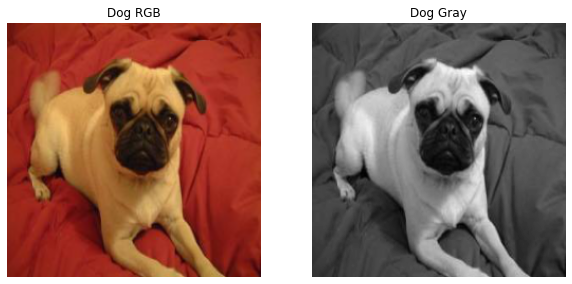

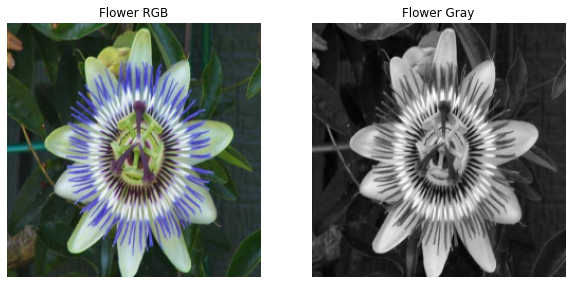

In [168]:
# Load images and preprocess the images
dog = imread('images/dog.jpg')
flower = imread('images/flower.jpg')

dog = resize(dog,(240,240))
flower = resize(flower,(240,240))

dog_gray = rgb2gray(dog)
flower_gray = rgb2gray(flower)

# Recolect the data for using the function
images = [dog_gray,flower_gray]
titles = ['Dog grayscale','Flower grayscale']
n_filters = [6,10]

# Visualise them
plot_images_line([dog, dog_gray], ["Dog RGB", "Dog Gray"], (10,5))
plot_images_line([flower, flower_gray], ["Flower RGB", "Flower Gray"], (10,5))

In [169]:
extract_features(images,titles,n_filters)

features of Dog grayscale image with 6 number of filters: 
[0.00677731 0.00666375 0.00771554 0.00893743 0.00874988 0.00778414]

features of Flower grayscale image with 10 number of filters: 
[0.01122807 0.01211678 0.01379493 0.01438382 0.01317932 0.01182924
 0.00754024 0.00829593 0.00931873 0.00973232]



### Visualizing features

**1.3** Make a function `visualize_features(im,  filter_bank, n_filters=5)` that recieves the `filter_bank`, an image `im` and an integer `n_filters`. 

The function  must make a plot of two rows containing in the first row, in position $k$, the image convolved by filter $k$. In the second row, in position $k$, the image of the k'th filter. The result for `n_filter=5` should look like 


<img src="./images/filters.png" >

**Hint**: Note that since at this moment we are focusing on the texture, we will not use the color of the images.

In [170]:
def visualize_features(im,  filter_bank, n_filters=5):
    """
    functions that visualize the result features after applying the filter
        im: image we want to convolve
        filter_bank: set of filter we have
        n_filter: number of filters we are using
    return: plotting n_filter images
    """
    fig, ax = plt.subplots(nrows=2, ncols=n_filters,figsize=(15,5))
    
    index = 0
    for i in range(2):
        for j in range(n_filters):
            convolved = convolve(im,filter_bank[:,:,j],mode = 'reflect')
            # print convolved images in the first row
            if i == 0:
                ax[i,j].imshow(abs(convolved), cmap = 'gray')
            # print filters in the second row
            elif i == 1:
                ax[i,j].imshow(filter_bank[:,:,j], cmap = 'gray')
            ax[i,j].set_title("Filter " + (str)(j+1))
            ax[i,j].axis("off")
    plt.show()

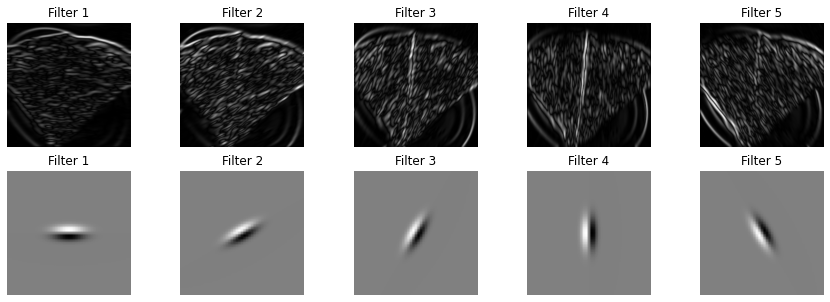

In [171]:
## Try the function for pizza image
visualize_features(pizza_gray, filter_bank)

**1.4** (Optional) Try ``visualize_filters()`` using a different number of filters and using another image (for instance ``/images/dog.jpg`` or ``/images/flower.jpg``)

In [172]:
def visualize_filters(images, titles, n_filters):
    # Use different number of filters for other images
    for i in range(len(images)):
        visualize_features(images[i], filter_bank,n_filters[i])
        print()
    return 

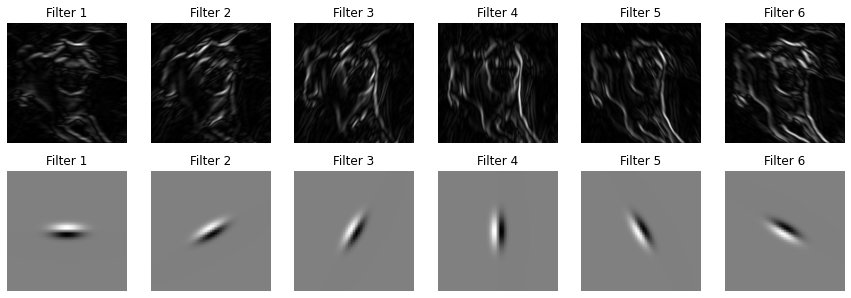

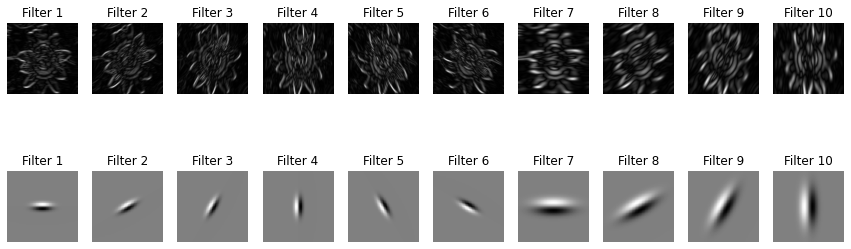

In [173]:
# Load images and preprocess the images
dog = imread('images/dog.jpg')
flower = imread('images/flower.jpg')

dog = resize(dog,(240,240))
flower = resize(flower,(240,240))

dog_gray = rgb2gray(dog)
flower_gray = rgb2gray(flower)

# Recolect the data for using the function
images = [dog_gray,flower_gray]
titles = ['Dog grayscale','Flower grayscale']
n_filters = [6,10]

# Using different number of filters
visualize_filters(images, titles, n_filters)

## 2 Load & resize the dataset

**2.1** Read all the images in the directories, resize them to 240x240 pixels and save the image in an array:

<ul>
    <li>./images/pizza/</li>
    <li>./images/flowers/</li>
    <li>./images/pets/</li>
</ul>

**Hint:** You have to create an array for each directory, which containts all the images belonging to that path.

In [174]:
directory_pizza= './images/pizza/'
directory_flowers = './images/flowers/'
directory_pets = './images/pets/'

# Or we can do it with list comprehensions
pizza_images = [imread(os.path.join(directory_pizza, filename)) for filename in os.listdir(directory_pizza)]
flowers_images = [imread(os.path.join(directory_flowers, filename)) for filename in os.listdir(directory_flowers)] 
pets_images = [imread(os.path.join(directory_pets, filename)) for filename in os.listdir(directory_pets)]

# Resize all images
pizza_images = [resize(im, (240, 240)) for im in pizza_images]
flowers_images = [resize(im, (240, 240)) for im in flowers_images]
pets_images = [resize(im, (240, 240)) for im in pets_images]

Visualize one image (the first) from each array. Use ``subplot`` to create a 3x1figure.

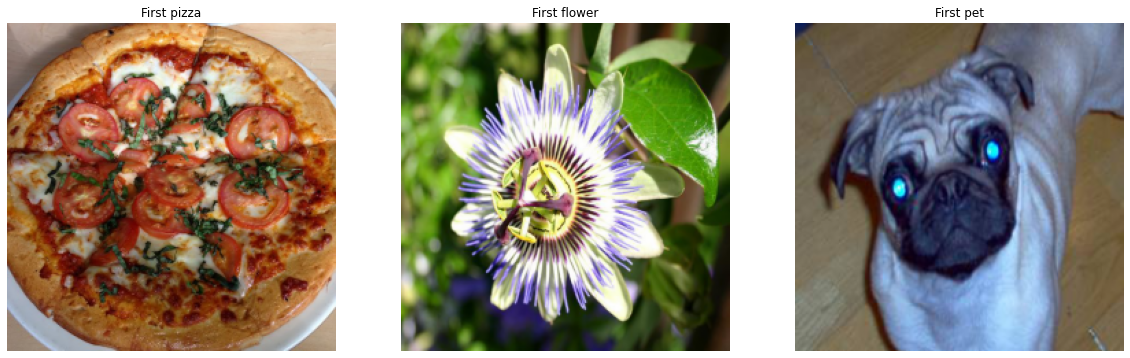

In [175]:
def visualize_first_image():
    first_pizza = pizza_images[0]
    first_flower = flowers_images[0]
    first_pet = pets_images[0]
    
    # The plot_images function uses subplot
    titles = ['First pizza', 'First flower', 'First pet']
    plot_images([first_pizza,first_flower,first_pet], titles, 3)

# Visualize first from each array
visualize_first_image()

How many images there are in each directory?

In [176]:
def print_len_directory():
    directories = [pizza_images,flowers_images,pets_images]
    directories_name = ['pizza_images','flowers_images','pets_images']
    for i in range(len(directories)):
        print('There are '+  str(len(directories[i])) + ' images in ' + directories_name[i] )
        
print_len_directory()

There are 30 images in pizza_images
There are 29 images in flowers_images
There are 29 images in pets_images


### Constructing the matrix of the feature vectors for all images

**2.2** Implement a function `get_dataset_features(all_images, filter_bank, n_filters=6)` that applies `extract_features` to get a feature vector for each of the images in the union of the three datasets (fish and chips_images, pizza, paella). It must return a matrix containing at row $k$ feature vector for the input image $k$.

Try the function with the whole data set:

*all_images = pizza_images + flowers_images + pets_images*

In [177]:
def get_dataset_features(all_images, filter_bank, n_filters = 6):
    """
    function which builds a matrix of the feature vectors for all images, which the size of each feature vector will be n_filters
        all_images: all images we want to save the feature in the matrix
        filter_bank: the data base of filters we have
        n_filters: number of filters we want to use
    returns:
        matrix of the feature vector of all the images
    """
    # We construct a matrix where each element of the matrix is a feature vector, and the size of this vector will be n_filters
    # So the size of matrix will be (len(all_images)x1)
    matrix = np.zeros((len(all_images), n_filters))
    
    for row in range (matrix.shape[0]):
        image = all_images[row]
        image_gray = rgb2gray(image)
        # This vector will have n_filters elements
        matrix[row] = get_image_features(image_gray, filter_bank, n_filters)
        
    return matrix


In [178]:
## Try the function for all the images we have
all_images = pizza_images + flowers_images + pets_images
feature_vectors = get_dataset_features(all_images, filter_bank)

**2.3** Print the shape of `feature_vectors` as well as the features for image #3 (*i.e. all_images[3]*), image #33, and image #53, directly from the vector

In [179]:
def print_feature_vector_row(feature_vectors,list_of_indexes):
    print('Shape of feature vectors : ' + str(feature_vectors.shape))
    for index in list_of_indexes:
        print('features for image ' + str(index) + ': ' + str(feature_vectors[index]))

indexes = [3,33,53]
print_feature_vector_row(feature_vectors,indexes)

Shape of feature vectors : (88, 6)
features for image 3: [0.01560833 0.01422984 0.01175954 0.01035192 0.01114906 0.0143554 ]
features for image 33: [0.00907681 0.00942882 0.01046935 0.01102623 0.01042927 0.00945317]
features for image 53: [0.01122807 0.01211678 0.01379493 0.01438382 0.01317932 0.01182924]


### Visualizing the features of an image

**2.4** Define a function `visualize_features(im_index, feature_vector)` that given three different images, plots their features. Use different colors (red, green, and blue) to distinguish the features of each image.
Choose 3 images on your choice and visualize the results.

In [180]:
import pandas as pd
def visualize_features(im_index, feature_vector):
    # red -> first image
    # green -> second image
    # blue -> third image
    df=pd.DataFrame({'x_values': range(0,len(feature_vector[0])), 'image1': np.array(feature_vector[im_index[0]]), 'image2': np.array(feature_vector[im_index[1]]), 'image3': np.array(feature_vector[im_index[2]]) })
 
    # multiple line plots
    plt.plot('x_values', 'image1', data=df, marker='', color='red', linewidth=2)
    plt.plot('x_values', 'image2', data=df, marker='', color='green', linewidth=2)
    plt.plot('x_values', 'image3', data=df, marker='', color='blue', linewidth=2)

    # show legend
    plt.legend()

    # show graph
    plt.show()

    return


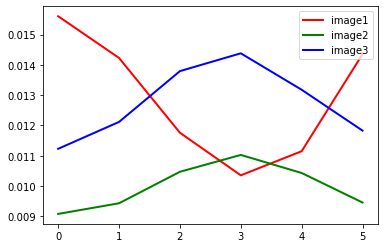

In [181]:
## Try the function
visualize_features([3,33,53], feature_vectors)

**2.5** (Optional) Try the function using a different set of images

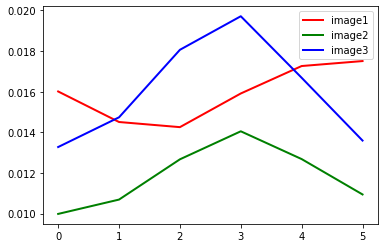

In [182]:
visualize_features([5,47,66] , feature_vectors)

Explain which features are most important to a given image and with each derivatives are related.

> We have seen in those exercises that all feature was described by the mean after applying a filter. So we have commontly three features, as first we introduced, the edges (first derivate of Gaussian) the bars (second derivates of Gaussian) and the spots (Laplacian Gaussian).


# 3 Retrieving the most similar images

### Similarity search

Let us assume $f(x) \in \mathbb{R}^D$ represents a set of features for $x$. Given a query image $x$ and another image $x^m$ from the database, we can compute the distance between images as
$$
\text{distance}\left( f(x) , \, f(x^m) \right) = \| \text{feat}(x)  - \text{feat}(x^m)  \|_2 =  \sqrt{ \sum_{d=1}^\text{D} \left( f(x)_d - f(x^m)_d  \right)^2 }
$$

then we can find the closest image $x^{m^*}$ from the database to $x$ as $m^* =  \text{argmin}_{m} \{ \| \text{feat}(x)  - \text{feat}(x^m)  \|_2 \}$



**3.1** Implement a function `retrieve_images(im_features, feature_vectors, k=5)` to retrieve and visualize the `k` most similar images (according to the l2 norm) to `im` and the corresponding distances.

The input of this function need to be feature of the image of interest `im_features`, the whole data set features `feature_vectors`, and an integer value `k`, which defines the number of images.

The function should return the ordered vector of distances and the index of the closests images.

In [183]:
def retrieve_images(im_features, feature_vectors, k=5):
    """
    function that returns a vector with the smallest distances and a vector with the corresponding indexes of these images
    both of size k
        im_features: the feature of the query image
        feature_vectors = the data set we total have, need to find in it the k most similar images
        k = number of the most similar images we want to find
    return:
        closest: the k indexes of the feature_vector that are most similar to the input image
        distances: the k distances of each closest image from the input image
    """
    closest = []
    distances = []
    
    dic = dict()
    
    # We loop for the 88 images to find their own distances
    for index, image in enumerate(feature_vectors):
        distance =  np.linalg.norm(im_features - feature_vectors[index])
        dic[index] = distance
    
    # sort dict
    dic = {k: v for k, v in sorted(dic.items(), key=lambda item: item[1])}
    closest = list(dic.keys())[0:k]
    distances = list(dic.values())[0:k]
    
    return closest, distances


Try your function using ``/images/pizza.jpg``.

In [184]:
## Try your function with pizza image
closest, distances = retrieve_images(im_features, feature_vectors, k=5)

**3.2** Write a function *show_closest_images(all_images, closest, distances)* to show the closest images and the corresponding distances. 

<img src="./images/indice.png" >


In [185]:
def show_closest_images(all_images, closest, distances):
    """
    function that shows the closest images given all the images
        closest : vector with the indexes of the closest images
        distances: vector with the distances of the closest images
    """
    if len(closest) > 5:
        n_fila = len(closest)//5
        n_col = len(closest)//n_fila
    else: 
        n_col = len(closest)
        
    images = [all_images[index] for index in closest]
    titles = ['Distance:' + str(dist) for dist in distances]
    
    plot_images(images,titles,n_col, figsize=(20,10))

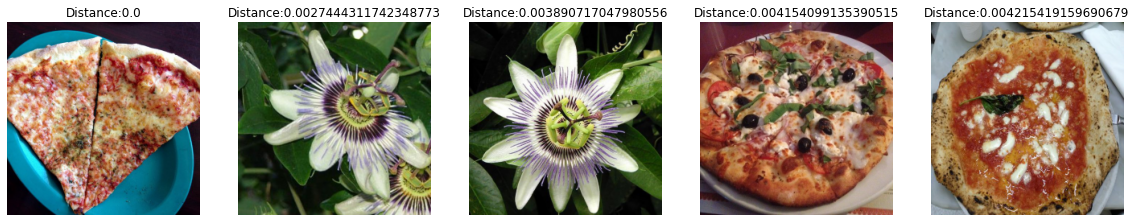

In [186]:
show_closest_images(all_images, closest, distances)

**3.3** Try your function using a different number of closest images `k`.

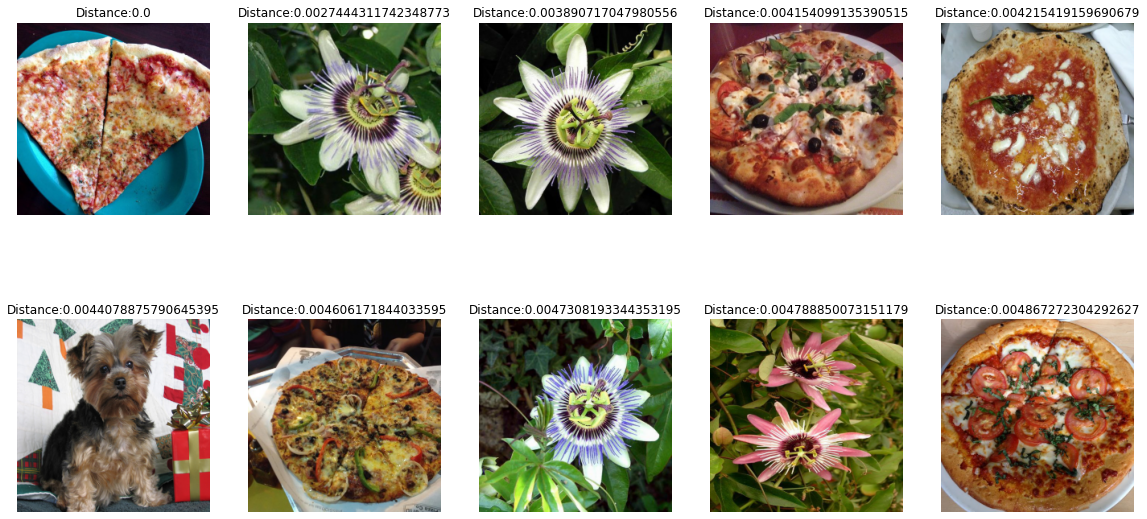

In [187]:
closest, distances = retrieve_images(im_features, feature_vectors, k=10)
show_closest_images(all_images, closest, distances)

**3.4** (Optional) Try your function using ``/images/dog.jpg``, and ``/images/flower.jpg``

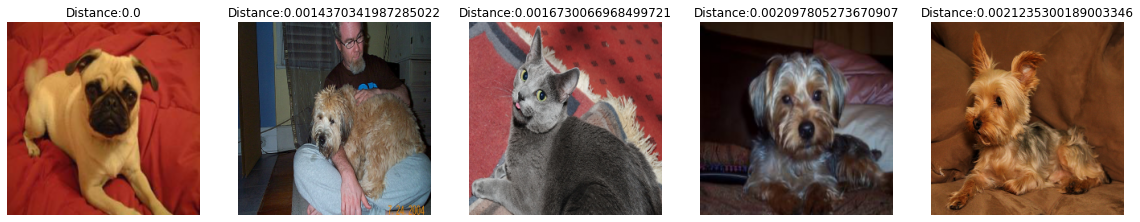

In [188]:
# For the dog image, k=5
im_features_dog = get_image_features(dog_gray, filter_bank, n_filters=6)
closest, distances = retrieve_images(im_features_dog, feature_vectors, k=5)
show_closest_images(all_images, closest, distances)

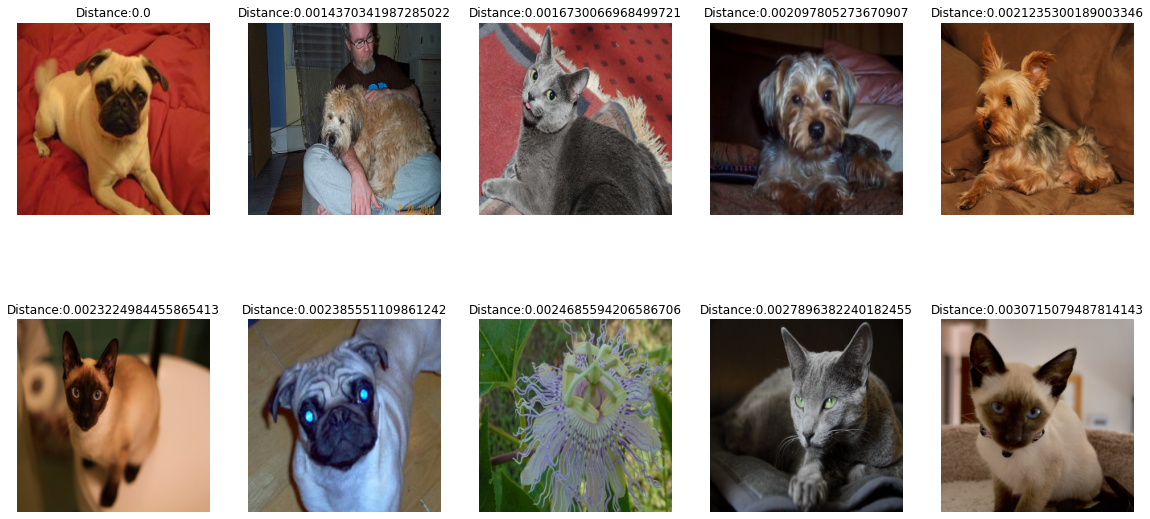

In [189]:
# For the dog image, k=10
im_features_dog = get_image_features(dog_gray, filter_bank, n_filters=6)
closest, distances = retrieve_images(im_features_dog, feature_vectors, k=10)
show_closest_images(all_images, closest, distances)

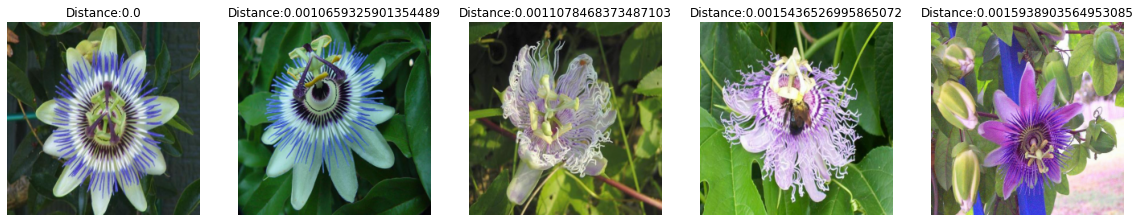

In [190]:
# For the flower image, k=5
im_features_flower = get_image_features(flower_gray, filter_bank, n_filters=6)
closest, distances = retrieve_images(im_features_flower, feature_vectors, k=5)
show_closest_images(all_images, closest, distances)

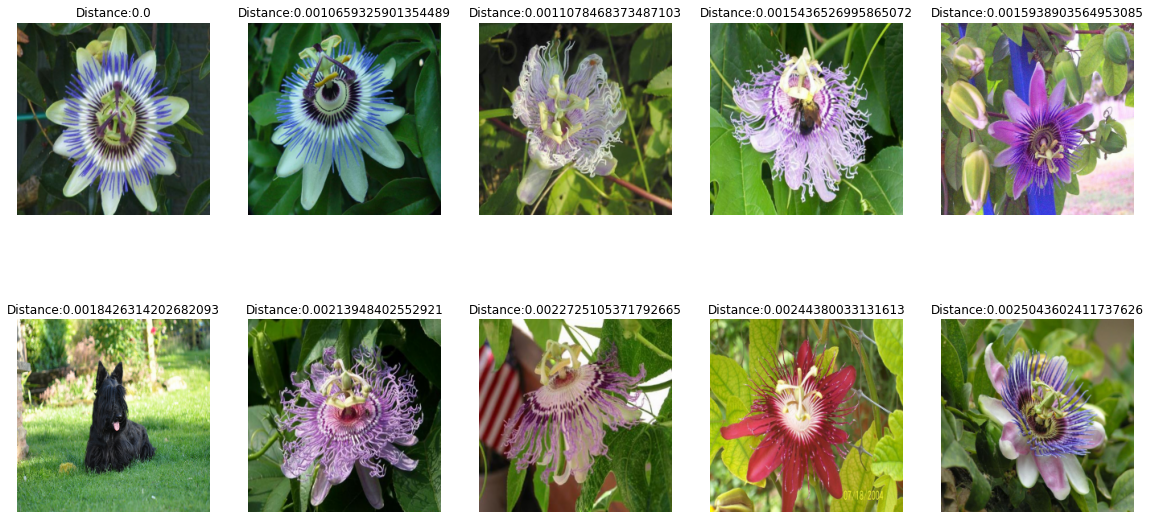

In [191]:
# For the flower image, k=10
im_features_flower = get_image_features(flower_gray, filter_bank, n_filters=6)
closest, distances = retrieve_images(im_features_flower, feature_vectors, k=10)
show_closest_images(all_images, closest, distances)

# 4 Compute the accuracy of the algorithm: given a query image. 

**4.1** Implement a function `accuracy(feature_vectors, class_labels, im_features, class_im,  k=5)`, which takes as input `feature_vectors`, the `class_labels` for the images (`0 = pizza`, `1 = flower` and `2 = pet`), the number of images to retrieve `k`, a query image (i.e. the feature vector for the image of interest) and the class of the query image `class_im`. 

Returns as output the number of retrieved images that belong to class `class_im` divided by the total of images retrieved `k` (this is the accuracy).

**Hint**: Be careful to exclude the query image from the retrieved images (i.e. those cases in which `distance=0.0`)

In [192]:
# It would be nice to have the image indexes to be able to sort them
def class_labels(index):
    """
    function that returns the class to which an image belongs given the index in all_images
        index: index of the image in all_images
    """
    
    if index <= len(pizza_images)-1:
        # class pizza
        return 0
    elif index >= len(pizza_images) and index <= (len(pizza_images) + len(flowers_images) -1):
        # class flowers
        return 1
    elif index >= (len(pizza_images) + len(flowers_images)) and index <= (len(pizza_images) + len(flowers_images) + len(pets_images)-1):
        # class pets
        return 2

In [193]:
def accuracy(im_features, class_labels, feature_vectors, class_im,  k=5):
    """
    function that returns the numeber of retrived images that belonged to the correct class divided by the total of images rerieved
        feature_vectors: feature vectors of all images
        class_labels: the class label of the query image
        im_features: features of the query image
        class_im: vector that determines the class of the image given its index
        k: lenght of the retrived images
    returns
        accuracy: a value
    """
    accuracy = 0
    # Get the closest images and their corresponding indexes
    closest, distances = retrieve_images(im_features, feature_vectors, k)
    
    # Look if the type of image is the same (flower, pet or pizza)
    for i in range(1,k):
        if class_im(closest[i]) == class_labels:
            accuracy += 1
    
    # We divide by the total of images retrieved
    accuracy /= (k-1)
    
    return accuracy


In [194]:
# Note: class_labels is a function
print("acc pizza k=5:", accuracy(im_features, 0, feature_vectors, class_labels, k=5))
print("acc flower k=5:", accuracy(im_features_flower, 1, feature_vectors, class_labels, k=5))
print("acc pet k=5:", accuracy(im_features_dog, 2, feature_vectors, class_labels, k=5))

acc pizza k=5: 0.5
acc flower k=5: 1.0
acc pet k=5: 1.0


Compute the accuracy with k=10 with the previous images. Does the accuracy match the images retrieved from the previous exercise?

In [195]:
print("acc pizza k=10:", accuracy(im_features, 0, feature_vectors, class_labels, k=10))
print("acc flower k=10:", accuracy(im_features_flower, 1, feature_vectors, class_labels, k=10))
print("acc pet k=10:", accuracy(im_features_dog, 2, feature_vectors, class_labels, k=10))

acc pizza k=10: 0.4444444444444444
acc flower k=10: 0.8888888888888888
acc pet k=10: 0.8888888888888888


> As we can see in the results, the accuracy matchs the images retrieved from the previous exercise.

**4.2** (Optional) Try your function using other images and modifying the number of filters to be used.

**Hint:** You can use `im_features = feature_vectors[j]` and `class_im = class_labels[j]`, for a given `j` value, in order to simplify the problem, instead of recomputing the features for a new image. **Remember** to exclude the query image from the retrieved images!.

In [196]:
print("With the nº35 image")
new_im_features = feature_vectors[35]
new_class_im = class_labels(35)
print("acc:", accuracy(new_im_features, new_class_im, feature_vectors, class_labels, k=5))
print("acc:", accuracy(new_im_features, new_class_im, feature_vectors, class_labels, k=10))
print("acc:", accuracy(new_im_features, new_class_im, feature_vectors, class_labels, k=20))
print("acc:", accuracy(new_im_features, new_class_im, feature_vectors, class_labels, k=30))

print("\nWith the nº67 image")
new_im_features = feature_vectors[67]
new_class_im = class_labels(67)
print("acc:", accuracy(new_im_features, new_class_im, feature_vectors, class_labels, k=5))
print("acc:", accuracy(new_im_features, new_class_im, feature_vectors, class_labels, k=10))
print("acc:", accuracy(new_im_features, new_class_im, feature_vectors, class_labels, k=20))
print("acc:", accuracy(new_im_features, new_class_im, feature_vectors, class_labels, k=30))

With the nº35 image
acc: 0.0
acc: 0.2222222222222222
acc: 0.47368421052631576
acc: 0.4827586206896552

With the nº67 image
acc: 0.75
acc: 0.4444444444444444
acc: 0.47368421052631576
acc: 0.41379310344827586


### Feature normalization

**4.3** As you can see in exercise 2.4, some features are higher than the rest and, therefore, they are "more important" during the image retrieving.

Normalize each feature between **[0,1]** using the minimum and the maximum values obtained from `feature_vectors`. Note that we need to use these values to normalize `im_features`.

Plot the new features of an image, using `visualize_features()`. Then, show the 5 closest images from `im_features` and compute the accuracy. Is there any difference? Do we obtain the same images than previously?

In [197]:
import joblib
# Normalize the feature_vector
def feature_normalization(feature_vector):
    """
    function that normalizes the feature vector
    """
    # Get the range to normalize
    rang = feature_vectors.max() - feature_vectors.min()
    
    # Normalize
    feature_vectors_normalized = (feature_vectors - feature_vectors.min())/rang
    
    return feature_vectors_normalized

def image_feature_normalization(image, feature_vectors, filter_bank,n_filters = 6):
    """
    function that normalizes just one image feature
    """
    image = get_image_features(image, filter_bank, n_filters = n_filters)
    return (image - np.min(feature_vectors))/(np.max(feature_vectors) - np.min(feature_vectors))

In [198]:
# Get the whole feature vector normalized
feature_vectors_norm = feature_normalization(feature_vectors)
# Get just one image feature vector normalized
im_features_norm = image_feature_normalization(pizza_gray, feature_vectors, filter_bank, n_filters = 6)

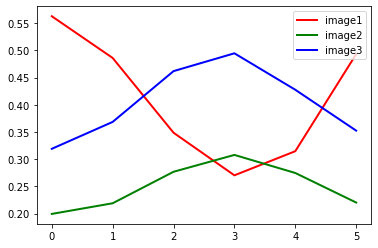

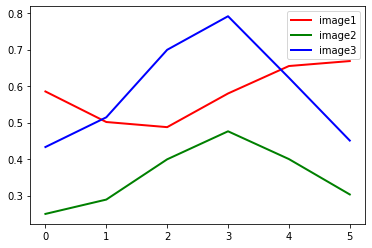

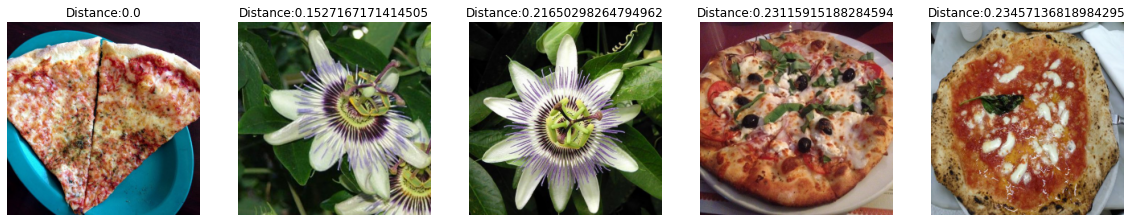

In [199]:
# Same as 2.4, we visualize the three image features
visualize_features([3,33,53], feature_vectors_norm)
visualize_features([5,47,66] , feature_vectors_norm)

# We plot the 5 closest images for the pizza image
closest, distances = retrieve_images(im_features_norm, feature_vectors_norm, k=5)
show_closest_images(all_images, closest, distances)

In [200]:
print("acc:", accuracy(im_features_norm, 0, feature_vectors_norm, class_labels, k=5))
print("acc:", accuracy(im_features_norm, 0, feature_vectors_norm, class_labels, k=10))

acc: 0.5
acc: 0.4444444444444444


> In this case no difference in precision has been presented, and the images remain the same as before to see the difference in normalization we could have tried with a higher number of filters

# 5 Image retrieval based on texture and color. 

**5.1** Make a function ` lm_features_rgb(rgb_image, n_bins=12)`  that returns the features based on a color descriptor (using histograms, as it was performed in the **Deliverable 3 - video segmentation**). 

**Hint:** How will you define it? What should be the dimensonality of the new descriptor?.

> The same as Deliverable 3, we just compute the histograms por each channel color of the rgb image, and then sum all of them. So the result dimension will be the number of bins we have give to the function.

In [201]:
from skimage import img_as_float
from skimage.exposure import histogram
def compute_hist(im, bins = 12):
    """
    Function compute the histogram for the three channels (rgb image)
    Parameters:
        im: image
        bins: quantity of bins uses per histogram
    Return:
        hist_im: result histogram feature of this image im
    """
    # Compute the histogram for each RGB channel considering that the type of the image is uint8
    [hist_r, bins_r]=histogram((img_as_float(im)[:,:,0]),bins)
    [hist_g, bins_g]=histogram((img_as_float(im)[:,:,1]),bins)
    [hist_b, bins_b]=histogram((img_as_float(im)[:,:,2]),bins)

    # The 'total' histogram of the image is computed as the sum of the three histograms
    hist_im = np.array(hist_r+hist_g+hist_b)
    
    return hist_im

In [202]:
def lm_features_rgb(rgb_image, n_bins=12):
    """
    Function that returns the features based on a color descriptor
    Parameters:
        rgb_image: image with 3 channels we want to get the feature
        n_bins: quantity of bins uses per histogram
    Return:
        hist_im: result histogram feature of this rgb image 
    """
    return compute_hist(rgb_image, n_bins)

In [203]:
# Try your function
lm_rgb_features = lm_features_rgb(pizza)
print(len(lm_rgb_features))

12



## Apply the function to all the images in the dataset

**5.2** Using ` lm_features_rgb` build the features of all the datapoints in and save them in `lm_dataset_features`.

**Hint:** You can parallelize the feature building process using `joblib.Parallel`. This will make the computation much faster if you have a processor with more than two threads.

In [217]:
%%time 
def get_dataset_features(all_images):
    # save features of all the datapoints using joblib.Parallel
    lm_dataset_features = joblib.Parallel(n_jobs=8)(joblib.delayed(lm_features_rgb)(im) for im in all_images)
    return lm_dataset_features
lm_dataset_features = get_dataset_features(all_images)

Wall time: 680 ms


In [218]:
import joblib
X_lm_rgb = joblib.Parallel(n_jobs=8)(joblib.delayed(lm_features_rgb)(im) for im in all_images)

## Compute the accuracy of the method using lm rgb features

**5.3** Compute the accuracy of the retrieved images using the features that contain color information. Make a plot of the 4 closest images to the query images in the `lm_rgb` space.

Is the accuracy higher? Please, comment the results.

In [206]:
# We are using the pizza for the initial tes
all_images = pizza_images + flowers_images + pets_images
# Get the color feature for one image
lm_rgb_features = lm_features_rgb(pizza)
# Get the color feature for all images
lm_dataset_features = get_feature_datapoints(all_images)

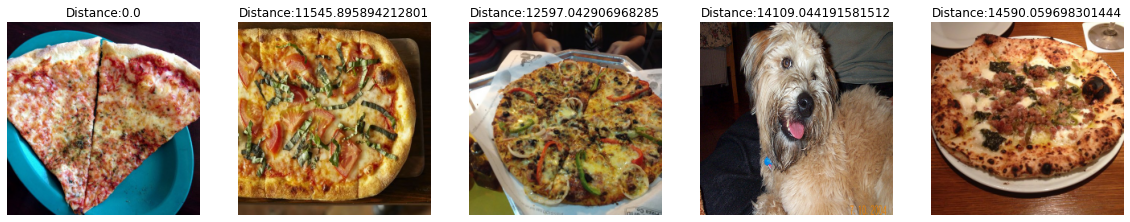

In [207]:
# Get the 4 most similar images and plot them
closest, distances = retrieve_images(lm_rgb_features, lm_dataset_features, k=5)
show_closest_images(all_images, closest, distances)

In [208]:
print("acc:", accuracy(lm_rgb_features, 0, lm_dataset_features, class_labels, k=5))

acc: 0.75


> As we can see from the results, the accuracy is higher, and from the images retrieved, there are more images that belong to the correct class.

## Compare the accuracy of the method using a) texture, b) color and c) texture + color  features

**5.4** Compute the accuracy of the retrieved images using the features that contain color information. Make a plot of the 4 closest images to the query images in the `lm_rgb` space.

Is the accuracy higher? Please, comment the results.

> That is the same exercice than 5.3. Here we will answer the question. The accuracy is higher when we use more bins, with that form we just make the algorithm of retrieval fastly, than the texture one.

**5.5** Compute the accuracy of the retrieved images using the features that contain texture and color information. Make a plot of the 4 closest images to the query images in the `lm_rgb_texture` space.

Is the accuracy higher? Please, comment the results.

In [209]:
# Now we need to compute the texture + color descriptor
def lm_features_rgb_texture(rgb_image, filter_bank, n_filters = 6, n_bins=12):
    """
    Function that returns the features based on a color descriptor
    Parameters:
        rgb_image: image with 3 channels we want to get the feature
        n_bins: quantity of bins uses per histogram
    Return:
        the both feature descritor in a array 
    """
    # Apply both descriptor
    image = rgb2gray(rgb_image)
    texture = get_image_features(image, filter_bank, n_filters)
    color = lm_features_rgb(rgb_image, n_bins)
    
    # Normalize them
    texture = (texture - texture.min())/(texture.max() - texture.min())
    color = (color - color.min())/(color.max() - color.min())
    
    return np.append(texture, color)

In [210]:
def get_feature_all_color_texture(all_images, filter_bank, n_filters = 6, n_bins=12):
    # Use the lm_features_rgb_texture function
    lm_rgb = joblib.Parallel(n_jobs=8)(joblib.delayed(lm_features_rgb_texture)(im, filter_bank, n_filters, n_bins) for im in all_images)
    lm_rgb = np.array(lm_rgb)
    return lm_rgb

In [211]:
# We use as known n_filter = 6 and n_bins = 12
text_color_features = lm_features_rgb_texture(pizza, filter_bank)
text_color_features_vector = get_feature_all_color_texture(all_images, filter_bank)

In [212]:
# So now the descritor lenght is the sum of the n_bins and n_filters uses
print(len(text_color_features))
print(len(text_color_features_vector))

18
88


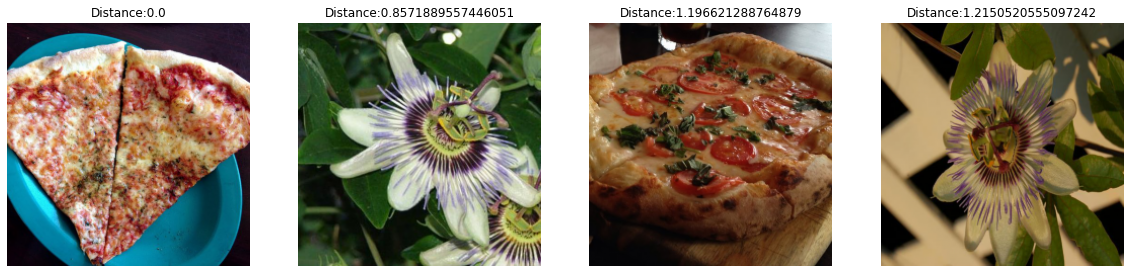

In [213]:
# Get the 4 most similar images and plot them
closest, distances = retrieve_images(text_color_features, text_color_features_vector, k=4)
show_closest_images(all_images, closest, distances)

In [214]:
# Print the accuracy of the three methods
print("A) Texture acc: ", accuracy(im_features, 0, feature_vectors, class_labels, k=5))
print("B) Color acc: ", accuracy(lm_rgb_features, 0, lm_dataset_features, class_labels, k=5))
print("C) Texture + Color acc: ", accuracy(text_color_features, 0, text_color_features_vector, class_labels, k=5))

A) Texture acc:  0.5
B) Color acc:  0.75
C) Texture + Color acc:  0.25


> The results, as we seen now, is better in the texture one. Remember that all these results depends on the important parameters like n_bins, n_filter and the type of image used (gray or rgb). In the color descriptor we just use the number of color of the image, so maybe two extremelly different images have similar quantity of colors. Then for the texture, it is more critical, because it describes the form it have, adn normally similar thing have similar forms (in general). And the last one, using color and texture, it will be better, but in that case it hasn't worked.

> Even sometimes the color descriptor can confuse, majority it helps to make sure which ones images that have similar textures is the one we are looking for the query image. So the conclution is that combine both descriptor will get better result for a big data set.
